In [8]:
import sys, os

from typing import TypeVar, Callable, Tuple, List, Dict, Any, Optional
from methods.MA import ma as method
import pandas as pd

import logging

from plots.color_map_by_method import get_color_map_by_method

from arch.unitroot import ADF
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.forecasting.stl import STLForecast

import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt

from data.dataset import Dataset, Result
from predictions.Prediction import PredictionData

from sklearn.model_selection import train_test_split


sys.path.append(os.path.abspath(os.path.join(os.path.dirname("."), "..")))
#
from data.electricity_consumption import energy_demand
from data.dataset import Dataset

Model = TypeVar("Model")

In [6]:
# load the data
dataset_object = energy_demand(zone=["CT"], scale=False)

data = dataset_object.values
display(data.head())

INFO:root:Imputing data for columns ['CT']
INFO:root:columns present: Index(['CT'], dtype='object', name='zone')
INFO:root:Shape of dataframe before imputation: (5175, 1)


Imputing data


zone,CT
ts,
2003-03-02,3254.000000
2003-03-09,3328.714286
2003-03-16,3268.714286
2003-03-23,2805.571429
2003-03-30,2732.285714


In [9]:

# split the data into training and test sets
training_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

training_data.shape, test_data.shape

((592, 1), (148, 1))

## Training a basic ARIMA model

First we need the model parameters

The p,d,q values can be specified using the order argument of ARIMA which take a tuple (p,d,q).

* p is the number of lag observations included in the model, also called the lag order.
* d is the number of times that the raw observations are differenced, also called the degree of differencing.
* q is the size of the moving average window, also called the order of moving average.

To determine the value of p, we can look at the ACF plot and see where the plot crosses the upper confidence interval for the first time.
The upper confidence interval is the blue shaded region in the plot below.

To determine the value of q, we can look at the PACF plot and see where the 
plot crosses the upper confidence interval for the first time.


* On the ACF the plot crossed the upper confidence interval at lag 6, so we can set p = 6.
* On the PACF there was a significant drop off at lag 2 or 3, so we can set q = 2.

From the earlier ACF and PACF plots, we can see that:
* p = 6 (from ACF)
* d = 0 (no differencing)
* q = 2 (from PACF)

In [10]:
(ar_order, integration_order, ma_order) = 6, 0, 2

In [13]:
# Let's train the ARIMA model on the training data

model = sm.tsa.arima.ARIMA(
    training_data["CT"],
    order=(ar_order, integration_order, ma_order),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

trained_model = model.fit()

/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/india-air-pollution-study-xopDDJl_-py3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
# Now let's make predictions on the test data

predictions = trained_model.predict(
    start=test_data.index[0], end=test_data.index[-1], dynamic=False
)
display(predictions.head())

2014-07-06    3077.032141
2014-07-13    3181.095757
2014-07-20    3251.641662
2014-07-27    3315.320778
2014-08-03    3364.209022
Freq: W-SUN, Name: predicted_mean, dtype: float64

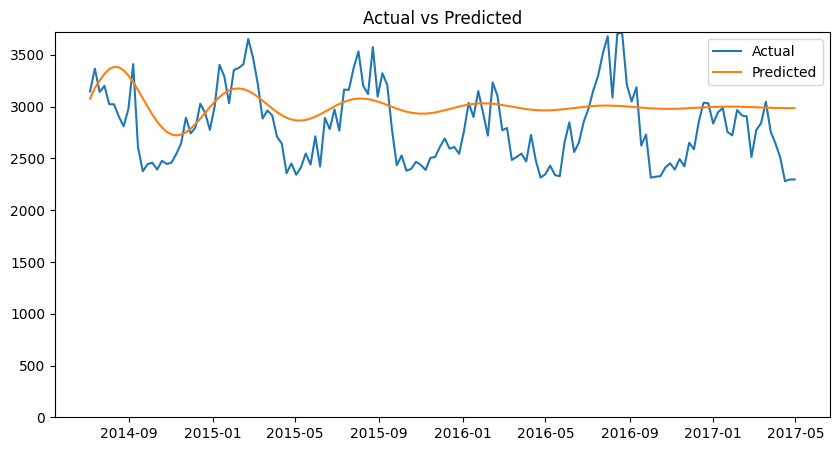

In [18]:
# Now let's plot the predictions against the actual values

plt.figure(figsize=(10, 5))
plt.plot(test_data["CT"], label="Actual")
plt.plot(predictions, label="Predicted")
plt.title("Actual vs Predicted")
plt.ylim(0, max(test_data["CT"].values.max() , predictions.values.max() ))
plt.legend()
plt.show()


# We can do better than this. 

* Let's try to find the best values for the AR, I and MA parameters using a grid search.
* Also, ARIMA doesn't work well with seasonality. So, let's try STLForecast which gives us a better way to handle seasonality.

Note: STLForecast is a seasonal-trend decomposition procedure based on loess. It decomposes a time series into seasonal, trend and residual components. It then applies ARIMA to the residuals and adds back the trend and seasonal components to get the final predictions.

In [ ]:
def __evaluate_models(
    data: Dataset, p_values: list, d_values: list, q_values: list, trend_values: list   
) -> Result:
    """Evaluate combinations of p, d and q values for an ARIMA model"""
    best_score, best_cfg, best_trend = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for t in trend_values:
                    order = (p, d, q)
                    try:
                        evaluation_metric = __evaluate_ma_model(
                            data, arima_order=order, trend=t
                        )
                        if evaluation_metric < best_score:
                            best_score, best_cfg, best_trend = evaluation_metric, order, t
                        logging.info(f"ARIMA{order} Trend={t} BIC={evaluation_metric}")
                    except Exception as e:
                        logging.error(f"ARIMA{order} Trend={t} failed with error: {e}")
                        continue
    logging.info(f"Best MA: {best_cfg} Best trend: {best_trend} BIC={best_score}")
    return best_cfg, best_trend

__p_values = [5, 6, 8] # autoregression
__d_values = [0, 1, 2] # differencing
__q_values = [0, 1, 2, 4] # moving average 
__trend_values = ["c", "t", "ct"] # trend

def __get_best_model_order(data: Dataset) -> Model:
    """Get the best model order for the ARIMA model"""
    return __evaluate_models(data, __p_values, __d_values, __q_values, __trend_values)
